In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Load Data
file_path = 'mv_waveform_2026-02-05.csv'
df = pd.read_csv(file_path)

# ใช้ข้อมูลจากแถวแรก (Snapshot 1 ชุด)
raw_text = str(df.iloc[0]['RAW_WAVEFORM'])

# 2. Parsing the RAW_WAVEFORM using GE Protocol
# ข้อมูลแต่ละบล็อกจะถูกคั่นด้วย =:VTw หรือ :VTw
blocks = raw_text.replace('=', '').split(':VTw')
# กรองเฉพาะบล็อกที่มีข้อมูลครบ 120 ตัวอักษร
blocks = [b.strip()[:120] for b in blocks if len(b.strip()) >= 120]

pressure_hex = ""
flow_hex = ""
volume_hex = ""

for b in blocks:
    pressure_hex += b[0:30]
    flow_hex += b[30:60]
    volume_hex += b[60:90]

# GE Scaling Function
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            s_val = int(h, 16)
            r_val = (s_val - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0
            vals.append(r_val)
        except:
            vals.append(0) # fallback
    return np.array(vals)

pressure = ge_scaling(pressure_hex, 0, 3584, -20, 120)
flow = ge_scaling(flow_hex, 512, 3584, -100, 100)
raw_volume = ge_scaling(volume_hex, 512, 3584, 0, 2000)

time_step = 0.04
time_axis = np.arange(0, len(pressure) * time_step, time_step)

# --- Plot 1: Decoded Raw Signals ---
fig, ax = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
ax[0].plot(time_axis, pressure, color='#1f77b4', linewidth=1.5)
ax[0].set_ylabel('Pressure\n(cmH2O)', fontweight='bold')
ax[0].set_title('Step 1: Raw Signal Decoding via GE Protocol', fontsize=14, fontweight='bold')
ax[0].grid(True, linestyle='--', alpha=0.6)

ax[1].plot(time_axis, flow, color='#ff7f0e', linewidth=1.5)
ax[1].set_ylabel('Flow\n(L/min)', fontweight='bold')
ax[1].axhline(0, color='black', linewidth=1)
ax[1].grid(True, linestyle='--', alpha=0.6)

ax[2].plot(time_axis, raw_volume, color='#2ca02c', linewidth=1.5)
ax[2].set_ylabel('Volume\n(ml)', fontweight='bold')
ax[2].set_xlabel('Time (seconds)', fontweight='bold')
ax[2].grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('01_decoded_signals.png')
plt.close()

# 3. Breath Segmentation
def segment_breaths(flow_signal, time_signal):
    flow_smooth = pd.Series(flow_signal).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    threshold = 2.0
    
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > threshold:
                inspiratory_starts.append(i)
                
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_signal[idx_end] - time_signal[idx_start]
        
        if duration > 0.5:
            breaths.append({
                'breath_id': k+1,
                'start_idx': idx_start,
                'end_idx': idx_end,
                'duration': duration,
                'pressure_segment': pressure[idx_start:idx_end],
                'flow_segment': flow[idx_start:idx_end],
                'volume_segment': raw_volume[idx_start:idx_end],
            })
    return breaths

detected_breaths = segment_breaths(flow, time_axis)

# 4. Feature Extraction & Flow Integration
features = []
for b in detected_breaths:
    f = {}
    f['breath_id'] = b['breath_id']
    f['PIP'] = np.max(b['pressure_segment'])
    f['PEEP'] = np.min(b['pressure_segment'])
    f['Max_Flow'] = np.max(b['flow_segment'])
    f['Duration'] = b['duration']
    
    # Flow Integration
    insp_flow = b['flow_segment'][b['flow_segment'] > 0]
    calculated_vt = np.sum(insp_flow) / 60 * time_step * 1000
    f['Calculated_Vt_ml'] = calculated_vt
    
    # Original Volume Peak (for comparison)
    f['Raw_Volume_Peak'] = np.max(b['volume_segment']) - b['volume_segment'][0] if len(b['volume_segment'])>0 else 0
    
    features.append(f)

df_features = pd.DataFrame(features)

# 5. Isolation Forest (AI Anomaly Detection)
if len(df_features) > 1:
    X_ai = df_features[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
    # Use contamination=0.2 roughly expecting 1-2 anomalies
    iso_forest = IsolationForest(contamination=0.2, random_state=42)
    df_features['Anomaly_Status'] = iso_forest.fit_predict(X_ai)
else:
    df_features['Anomaly_Status'] = 1 # Not enough data to cluster

print("=== Final AI Feature Matrix ===")
print(df_features[['breath_id', 'PIP', 'Max_Flow', 'Calculated_Vt_ml', 'Anomaly_Status']].to_string(index=False))

# --- Plot 2: AI Cluster Plot ---
if len(df_features) > 1:
    plt.figure(figsize=(10, 6))
    colors = ['red' if x == -1 else 'blue' for x in df_features['Anomaly_Status']]
    plt.scatter(df_features['PIP'], df_features['Calculated_Vt_ml'], c=colors, s=150, edgecolors='black', alpha=0.7)

    for i, txt in enumerate(df_features['breath_id']):
        label = "Anomaly" if df_features.iloc[i]['Anomaly_Status'] == -1 else "Normal"
        plt.annotate(f"B{txt} ({label})", 
                     (df_features.iloc[i]['PIP']+0.2, df_features.iloc[i]['Calculated_Vt_ml']), 
                     fontsize=11, fontweight='bold')

    plt.title('Step 4: AI Anomaly Detection (Isolation Forest)', fontsize=14, fontweight='bold')
    plt.xlabel('Peak Inspiratory Pressure (PIP) [cmH2O]', fontweight='bold')
    plt.ylabel('Integrated Tidal Volume (Vt) [ml]', fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('02_ai_clustering.png')
    plt.close()

=== Final AI Feature Matrix ===
 breath_id       PIP  Max_Flow  Calculated_Vt_ml  Anomaly_Status
         1 19.335938 79.296875        870.833333              -1
         2 19.335938 66.927083        765.321181               1
         3 19.335938 63.085938        515.581597               1


In [3]:
# Import Libraries & Load Data
# นำเข้าไลบรารีสำหรับจัดการข้อมูลตัวเลขและตาราง
import pandas as pd
import numpy as np

# นำเข้าไลบรารีสำหรับวาดกราฟ
import matplotlib.pyplot as plt

# นำเข้าโมเดล AI (Isolation Forest) สำหรับตรวจจับความผิดปกติ
from sklearn.ensemble import IsolationForest

# โหลดไฟล์ข้อมูลเซ็นเซอร์เครื่องช่วยหายใจ
file_path = 'mv_waveform_2026-02-05.csv'
df = pd.read_csv(file_path)

# เลือกข้อมูลแถวแรกสุดมาใช้งาน (หรือเปลี่ยน index ถ้าต้องการดูคนไข้เคสอื่น)
# เราจะดึงเฉพาะคอลัมน์ RAW_WAVEFORM ที่เป็นโค้ดฐาน 16 (Hexadecimal) ออกมา
raw_text = str(df.iloc[0]['RAW_WAVEFORM'])

print("โหลดข้อมูลสำเร็จ! ความยาวของข้อมูลดิบ:", len(raw_text), "ตัวอักษร")

โหลดข้อมูลสำเร็จ! ความยาวของข้อมูลดิบ: 3125 ตัวอักษร


In [4]:
# ลบเครื่องหมาย '=' ทิ้ง และใช้คำว่า ':VTw' เป็นจุดตัดแบ่งข้อมูลออกเป็นบล็อกๆ
blocks = raw_text.replace('=', '').split(':VTw')

# กรองเอาเฉพาะบล็อกที่มีความยาวครบ 120 ตัวอักษร (ตามมาตรฐาน 1 Cycle)
blocks = [b.strip()[:120] for b in blocks if len(b.strip()) >= 120]

# สร้างตัวแปร String ว่างๆ ไว้เก็บโค้ด Hex ของแต่ละเซ็นเซอร์
pressure_hex = ""
flow_hex = ""
volume_hex = ""

# วนลูปนำข้อมูลแต่ละบล็อกมาต่อกันให้เป็นสายยาวๆ
# อ้างอิงตาม GE Protocol: 30 ตัวแรกคือ Pressure, 30 ตัวถัดมาคือ Flow, 30 ตัวถัดมาคือ Volume
for b in blocks:
    pressure_hex += b[0:30]
    flow_hex += b[30:60]
    volume_hex += b[60:90]

print(f"เตรียมข้อมูล Hex สำเร็จ: ได้ข้อมูลทั้งหมด {len(pressure_hex)//3} จุด (Data Points)")

เตรียมข้อมูล Hex สำเร็จ: ได้ข้อมูลทั้งหมด 250 จุด (Data Points)


In [5]:

# GE Protocol Decoding & Time Axis

# สร้างฟังก์ชันสำหรับแปลงโค้ด Hex เป็นตัวเลข (อ้างอิงสมการ Linear Scaling จากคู่มือ GE)
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    # สับ String ยาวๆ ออกเป็นชิ้นละ 3 ตัวอักษร
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    
    for h in chunks:
        try:
            # 1. แปลงเลขฐาน 16 (Hex) เป็นฐาน 10 (Decimal)
            s_val = int(h, 16)
            # 2. เข้าสมการเทียบบัญญัติไตรยางศ์ (Linear Interpolation)
            r_val = (s_val - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0
            vals.append(r_val)
        except:
            vals.append(0) # กรณีมีอักขระแปลกปลอม ให้ใส่ 0 ป้องกัน error
            
    return np.array(vals)

# เรียกใช้ฟังก์ชันแปลงค่า (ใส่ค่าพารามิเตอร์ตามคู่มือของแต่ละเซ็นเซอร์)
pressure = ge_scaling(pressure_hex, 0, 3584, -20, 120)
flow = ge_scaling(flow_hex, 512, 3584, -100, 100)
raw_volume = ge_scaling(volume_hex, 512, 3584, 0, 2000)

# สร้างแกนเวลา (Time Axis) โดยอิงตาม Sampling Rate = 40 ms (0.04 วินาที) ต่อ 1 ค่า
time_step = 0.04
time_axis = np.arange(0, len(pressure) * time_step, time_step)

print("ถอดรหัสสัญญาณเสร็จสิ้น! ตอนนี้ได้ตัวเลขทางการแพทย์ที่นำไปพล็อตกราฟได้แล้ว")

ถอดรหัสสัญญาณเสร็จสิ้น! ตอนนี้ได้ตัวเลขทางการแพทย์ที่นำไปพล็อตกราฟได้แล้ว


In [6]:
# Breath Segmentation (Zero-Crossing)


def segment_breaths(flow_signal, time_signal):
    # ทำ Moving Average แบบง่ายๆ เพื่อลด Noise ของสัญญาณแกว่ง (Smooth signal)
    flow_smooth = pd.Series(flow_signal).rolling(window=3, center=True).mean().fillna(0).values
    
    inspiratory_starts = []
    threshold = 2.0 # กำหนดว่า Flow ต้องขึ้นไปเกิน 2 L/min ถึงจะนับว่าพยายามหายใจเข้าจริงๆ
    
    # วนลูปหาจุดที่ Flow วิ่งจากติดลบไปเป็นบวก (จุดเริ่มต้นการหายใจเข้า)
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            # เช็คยืนยันไปข้างหน้าอีก 5 จุดว่าค่าพุ่งขึ้นจริง ไม่ใช่แค่สไปค์ (Spike) ของสัญญาณ
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > threshold:
                inspiratory_starts.append(i)
                
    breaths = []
    
    # วนลูปนำจุดเริ่มต้น มาจับคู่กันเพื่อหั่นกราฟออกเป็นท่อนๆ
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_signal[idx_end] - time_signal[idx_start]
        
        # คัดกรอง Noise: ลมหายใจ 1 รอบต้องใช้เวลาเกิน 0.5 วินาที
        if duration > 0.5:
            breaths.append({
                'breath_id': k+1,
                'start_idx': idx_start,
                'end_idx': idx_end,
                'duration': duration,
                'pressure_segment': pressure[idx_start:idx_end],
                'flow_segment': flow[idx_start:idx_end],
                'volume_segment': raw_volume[idx_start:idx_end],
            })
    return breaths

# เรียกใช้ฟังก์ชันตัดแบ่งลมหายใจ
detected_breaths = segment_breaths(flow, time_axis)
print(f"ตัดแบ่งลมหายใจอัตโนมัติสำเร็จ! พบลมหายใจทั้งหมด {len(detected_breaths)} ครั้ง")

ตัดแบ่งลมหายใจอัตโนมัติสำเร็จ! พบลมหายใจทั้งหมด 3 ครั้ง


In [7]:

# Feature Extraction & Flow Integration


features = []

# วนลูปเข้าไปในลมหายใจแต่ละครั้งที่ตัดมาได้
for b in detected_breaths:
    f = {}
    f['breath_id'] = b['breath_id']
    f['PIP'] = np.max(b['pressure_segment']) # หาค่าความดันสูงสุด (Peak Inspiratory Pressure)
    f['PEEP'] = np.min(b['pressure_segment']) # หาค่าความดันต่ำสุดตอนหายใจออก
    f['Max_Flow'] = np.max(b['flow_segment']) # หาอัตราการไหลสูงสุด
    f['Duration'] = b['duration'] # ระยะเวลาหายใจ 1 รอบ
    
    # 🌟 ท่าไม้ตาย (Flow Integration) 🌟
    # คัดเฉพาะช่วงที่หายใจเข้า (Flow เป็นบวก)
    insp_flow = b['flow_segment'][b['flow_segment'] > 0]
    
    # คำนวณพื้นที่ใต้กราฟ: (Flow ลิตร/นาที) / 60 วินาที * (0.04 วินาที) * 1000 (แปลงเป็น ml)
    calculated_vt = np.sum(insp_flow) / 60 * time_step * 1000
    f['Calculated_Vt_ml'] = calculated_vt
    
    features.append(f)

# แปลงผลลัพธ์ให้อยู่ในรูปแบบตาราง (DataFrame)
df_features = pd.DataFrame(features)
print("สกัดฟีเจอร์และคำนวณ Volume ใหม่สำเร็จ!")
print(df_features[['breath_id', 'PIP', 'Max_Flow', 'Calculated_Vt_ml']])

สกัดฟีเจอร์และคำนวณ Volume ใหม่สำเร็จ!
   breath_id        PIP   Max_Flow  Calculated_Vt_ml
0          1  19.335938  79.296875        870.833333
1          2  19.335938  66.927083        765.321181
2          3  19.335938  63.085938        515.581597


In [8]:
#AI Anomaly Detection (Isolation Forest)

# เช็คก่อนว่ามีลมหายใจมากพอให้ AI จัดกลุ่มหรือไม่ (ต้องมี > 1 ครั้ง)
if len(df_features) > 1:
    # เลือกตัวแปร (Features) ที่จะให้ AI เรียนรู้
    X_ai = df_features[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
    
    # สร้างโมเดล Isolation Forest
    # contamination=0.2 หมายถึง เราคาดเดาว่าอาจจะมีความผิดปกติปะปนอยู่ประมาณ 20%
    iso_forest = IsolationForest(contamination=0.2, random_state=42)
    
    # สั่งให้ AI เรียนรู้และตัดสินใจเลย (Fit and Predict)
    # ผลลัพธ์: 1 = ปกติ (Normal), -1 = ผิดปกติ (Anomaly)
    df_features['Anomaly_Status'] = iso_forest.fit_predict(X_ai)
else:
    # ถ้ามีลมหายใจแค่ 1 ครั้ง AI จะเปรียบเทียบไม่ได้ ให้ตีเป็นปกติไปก่อน
    df_features['Anomaly_Status'] = 1 

print("\n=== ผลลัพธ์การประเมินจากสมองกล AI ===")
print(df_features[['breath_id', 'PIP', 'Calculated_Vt_ml', 'Anomaly_Status']].to_string(index=False))


=== ผลลัพธ์การประเมินจากสมองกล AI ===
 breath_id       PIP  Calculated_Vt_ml  Anomaly_Status
         1 19.335938        870.833333              -1
         2 19.335938        765.321181               1
         3 19.335938        515.581597               1


จำนวน Snapshot ทั้งหมดในไฟล์: 1272 แถว

ประมวลผลเสร็จสิ้น 1233 แถว
สกัดลมหายใจ (Breath Cycles) ได้ทั้งหมดรวม: 2220 ครั้ง

=== สรุปผลการตรวจจับจาก AI ===
ลมหายใจปกติ (Normal): 2109 ครั้ง
ลมหายใจผิดปกติ/ต้านเครื่อง (Anomaly): 111 ครั้ง

[ตัวอย่างข้อมูลที่ AI มองว่าผิดปกติ]
       AdmissionID  R_ID  Breath_No        PIP  Calculated_Vt_ml
7    1707156033287  1049          1  19.375000        922.612847
14   1707221031263  1053          1   5.546875          7.291667
52   1705159935406  1073          5  20.312500         22.092014
93   1707451835911  1094          2  20.351562         29.991319
100  1707451835911  1097          3  20.351562         32.204861


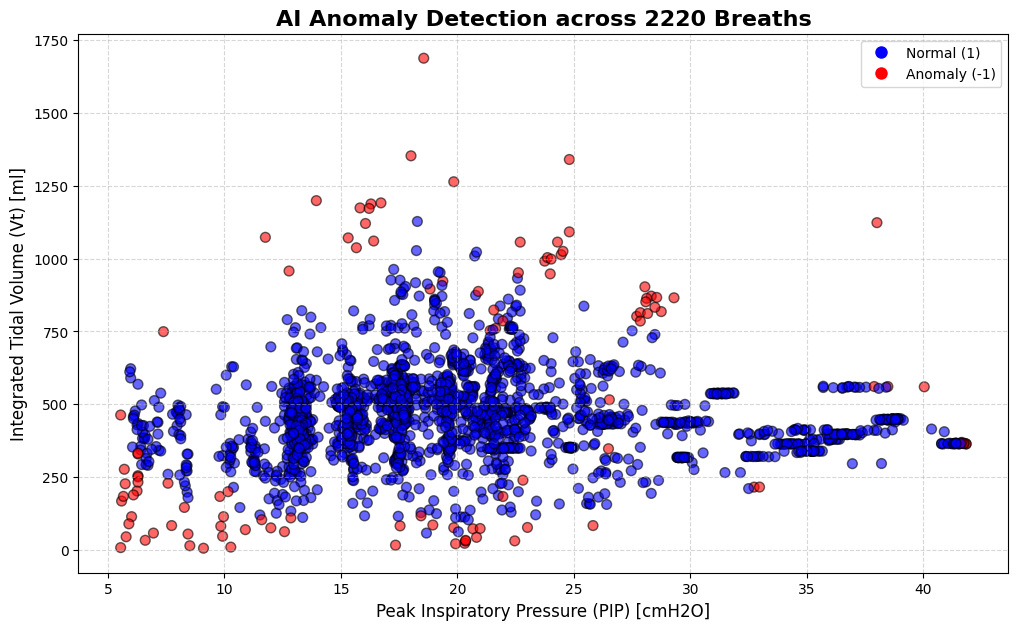

In [9]:

# FULL BATCH PROCESSING PIPELINE (รันทุกข้อมูล)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. โหลดข้อมูลทั้งหมดจากไฟล์ CSV
file_path = 'mv_waveform_2026-02-05.csv'
df = pd.read_csv(file_path)
print(f"จำนวน Snapshot ทั้งหมดในไฟล์: {len(df)} แถว")

# ------------------------------------------
# ฟังก์ชันมาตรฐาน (กำหนดไว้ใช้งานในลูป)
# ------------------------------------------
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            s_val = int(h, 16)
            r_val = (s_val - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0
            vals.append(r_val)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths(flow_signal, time_signal):
    flow_smooth = pd.Series(flow_signal).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    threshold = 2.0
    
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > threshold:
                inspiratory_starts.append(i)
                
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_signal[idx_end] - time_signal[idx_start]
        if duration > 0.5:
            breaths.append({
                'breath_id': k+1,
                'start_idx': idx_start,
                'end_idx': idx_end,
                'duration': duration,
                'pressure_segment': pressure[idx_start:idx_end],
                'flow_segment': flow[idx_start:idx_end]
            })
    return breaths

# ------------------------------------------
# 2. เริ่มลูปดึงข้อมูลทุกแถว (Batch Processing)
# ------------------------------------------
all_features = [] # ลิสต์สำหรับเก็บลมหายใจของ 'ทุกคน' รวมกัน
total_processed_rows = 0

for index, row in df.iterrows():
    # ดึงข้อมูลที่จำเป็นของแต่ละแถว
    raw_text = str(row['RAW_WAVEFORM'])
    r_id = row['R_ID']
    admission_id = row['AdmissionID']
    
    # ข้ามแถวที่ไม่มีข้อมูล RAW_WAVEFORM
    if pd.isna(raw_text) or raw_text == 'nan':
        continue
        
    # หั่นบล็อกข้อมูล
    blocks = raw_text.replace('=', '').split(':VTw')
    blocks = [b.strip()[:120] for b in blocks if len(b.strip()) >= 120]
    
    if not blocks:
        continue
        
    pressure_hex, flow_hex, volume_hex = "", "", ""
    for b in blocks:
        pressure_hex += b[0:30]
        flow_hex += b[30:60]
        volume_hex += b[60:90]

    # ถอดรหัส (Decoding)
    pressure = ge_scaling(pressure_hex, 0, 3584, -20, 120)
    flow = ge_scaling(flow_hex, 512, 3584, -100, 100)
    
    time_step = 0.04
    time_axis = np.arange(0, len(pressure) * time_step, time_step)

    # ตัดแบ่งลมหายใจ (Segmentation)
    detected_breaths = segment_breaths(flow, time_axis)
    
    # สกัด Feature & Flow Integration ของแถวนี้
    for b in detected_breaths:
        insp_flow = b['flow_segment'][b['flow_segment'] > 0]
        calculated_vt = np.sum(insp_flow) / 60 * time_step * 1000
        
        # เก็บข้อมูลลงในคลังกลาง (มี R_ID และ AdmissionID กำกับเพื่อระบุตัวคนไข้)
        all_features.append({
            'R_ID': r_id,
            'AdmissionID': admission_id,
            'Breath_No': b['breath_id'],
            'PIP': np.max(b['pressure_segment']),
            'Max_Flow': np.max(b['flow_segment']),
            'Duration': b['duration'],
            'Calculated_Vt_ml': calculated_vt
        })
    
    total_processed_rows += 1

# แปลงเป็น DataFrame เพื่อส่งให้ AI
df_all_features = pd.DataFrame(all_features)
print(f"\nประมวลผลเสร็จสิ้น {total_processed_rows} แถว")
print(f"สกัดลมหายใจ (Breath Cycles) ได้ทั้งหมดรวม: {len(df_all_features)} ครั้ง")

# ------------------------------------------
# 3. AI Anomaly Detection (รันทีเดียวบนข้อมูลทั้งหมด)
# ------------------------------------------
if len(df_all_features) > 1:
    # เลือกตัวแปรให้ AI เรียนรู้
    X_ai = df_all_features[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
    
    # กำหนด Contamination (คาดว่ามี Asynchrony เกิดขึ้นกี่เปอร์เซ็นต์ เช่น 5% หรือ 0.05)
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    
    # หาความผิดปกติ
    df_all_features['Anomaly_Status'] = iso_forest.fit_predict(X_ai)
    
    # นับจำนวนลมหายใจปกติและผิดปกติ
    anomalies = df_all_features[df_all_features['Anomaly_Status'] == -1]
    normal = df_all_features[df_all_features['Anomaly_Status'] == 1]
    
    print(f"\n=== สรุปผลการตรวจจับจาก AI ===")
    print(f"ลมหายใจปกติ (Normal): {len(normal)} ครั้ง")
    print(f"ลมหายใจผิดปกติ/ต้านเครื่อง (Anomaly): {len(anomalies)} ครั้ง")
    
    # แสดงตัวอย่างลมหายใจที่ผิดปกติ (โชว์ว่ามาจากคนไข้ ID ไหนบ้าง)
    print("\n[ตัวอย่างข้อมูลที่ AI มองว่าผิดปกติ]")
    print(anomalies[['AdmissionID', 'R_ID', 'Breath_No', 'PIP', 'Calculated_Vt_ml']].head())
    
    # พล็อตกราฟจุด (Scatter Plot) ของข้อมูลทั้งหมด
    plt.figure(figsize=(12, 7))
    colors = ['red' if x == -1 else 'blue' for x in df_all_features['Anomaly_Status']]
    plt.scatter(df_all_features['PIP'], df_all_features['Calculated_Vt_ml'], c=colors, s=50, alpha=0.6, edgecolors='black')
    
    plt.title(f'AI Anomaly Detection across {len(df_all_features)} Breaths', fontsize=16, fontweight='bold')
    plt.xlabel('Peak Inspiratory Pressure (PIP) [cmH2O]', fontsize=12)
    plt.ylabel('Integrated Tidal Volume (Vt) [ml]', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # สร้าง Custom Legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Normal (1)', markerfacecolor='blue', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Anomaly (-1)', markerfacecolor='red', markersize=10)]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.show()
else:
    print("พบข้อมูลน้อยเกินไป ไม่สามารถรันโมเดล AI ได้")

In [10]:
print(anomalies[['AdmissionID', 'R_ID', 'Breath_No', 'PIP', 'Calculated_Vt_ml']])

        AdmissionID  R_ID  Breath_No        PIP  Calculated_Vt_ml
7     1707156033287  1049          1  19.375000        922.612847
14    1707221031263  1053          1   5.546875          7.291667
52    1705159935406  1073          5  20.312500         22.092014
93    1707451835911  1094          2  20.351562         29.991319
100   1707451835911  1097          3  20.351562         32.204861
...             ...   ...        ...        ...               ...
2214  1770197347350  2314          1  24.453125       1013.498264
2215  1770197347350  2314          2  24.296875       1056.987847
2217  1770197347350  2316          1  24.531250       1025.173611
2218  1770197347350  2316          2  24.804688       1092.100694
2219  1770197347350  2317          1  24.023438        998.437500

[111 rows x 5 columns]


#Clinical Sub-typing

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [12]:
file_path = 'mv_waveform_2026-02-05.csv'
df = pd.read_csv(file_path).dropna(subset=['RAW_WAVEFORM'])


# 1. PREPROCESSING & SIGNAL RECONSTRUCTION
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            s_val = int(h, 16)
            r_val = (s_val - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0
            vals.append(r_val)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths_advanced(pressure_signal, flow_signal, time_signal):
    flow_smooth = pd.Series(flow_signal).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    threshold = 2.0
    
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > threshold:
                inspiratory_starts.append(i)
                
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_signal[idx_end] - time_signal[idx_start]
        
        if duration > 0.5:
            # หาจุดที่เปลี่ยนจากหายใจเข้าเป็นหายใจออก (Flow ตัดศูนย์กลับลงมา)
            insp_flow_segment = flow_signal[idx_start:idx_end]
            # หา index ที่ flow ต่ำกว่า 0 ครั้งแรกหลังจากเริ่มหายใจ
            zero_crossings = np.where(insp_flow_segment < 0)[0]
            if len(zero_crossings) > 0:
                insp_end_idx = idx_start + zero_crossings[0]
            else:
                insp_end_idx = idx_end # fallback
                
            breaths.append({
                'breath_id': k+1,
                'start_idx': idx_start,
                'insp_end_idx': insp_end_idx,
                'end_idx': idx_end,
                'duration': duration,
                'pressure_segment': pressure_signal[idx_start:idx_end],
                'flow_segment': flow_signal[idx_start:idx_end]
            })
    return breaths

all_features = []
raw_waveforms_dl = [] # สำหรับ Deep Learning

time_step = 0.04
for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex = "", ""
    for b in blocks:
        p_hex += b[0:30]
        f_hex += b[30:60]

    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)

    breaths = segment_breaths_advanced(pressure, flow, time_axis)
    
    for b in breaths:
        
        # ทิศทางที่ 3: Advanced Morphological Features
        
        insp_flow = flow[b['start_idx']:b['insp_end_idx']]
        exp_flow = flow[b['insp_end_idx']:b['end_idx']]
        
        # 1. Calculated Vt (Flow Integration)
        vt_ml = np.sum(insp_flow[insp_flow > 0]) / 60 * time_step * 1000
        
        # 2. Duty Cycle (Ti/Ttot)
        t_insp = (b['insp_end_idx'] - b['start_idx']) * time_step
        t_tot = b['duration']
        duty_cycle = t_insp / t_tot if t_tot > 0 else 0
        
        # 3. Work of Breathing (WOB) Approximate: Sum(Pressure * Flow * dt)
        insp_pressure = pressure[b['start_idx']:b['insp_end_idx']]
        # แปลง Flow L/min -> L/s
        wob_approx = np.sum(insp_pressure * (insp_flow/60) * time_step) 
        
        all_features.append({
            'AdmissionID': row['AdmissionID'],
            'R_ID': row['R_ID'],
            'PIP': np.max(b['pressure_segment']),
            'Max_Flow': np.max(b['flow_segment']),
            'Calculated_Vt_ml': vt_ml,
            'Duty_Cycle': duty_cycle,
            'WOB_Approx': wob_approx
        })
        
        # เก็บกราฟ Flow ความยาวคงที่ 60 จุด (2.4 วินาที) สำหรับ Deep Learning
        f_seg = b['flow_segment']
        if len(f_seg) >= 60:
            raw_waveforms_dl.append(f_seg[:60])
        else:
            raw_waveforms_dl.append(np.pad(f_seg, (0, 60 - len(f_seg)), 'constant'))

df_feat = pd.DataFrame(all_features)
print(f"สกัดฟีเจอร์สำเร็จ {len(df_feat)} ลมหายใจ")


สกัดฟีเจอร์สำเร็จ 2220 ลมหายใจ


In [13]:
# BASELINE: หา Anomalies ก่อน (Isolation Forest)
X = df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml', 'Duty_Cycle', 'WOB_Approx']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso = IsolationForest(contamination=0.1, random_state=42) # คาดว่ามีผิดปกติ 10%
df_feat['Anomaly'] = iso.fit_predict(X_scaled)

# ทิศทางที่ 1: Clinical Sub-typing (K-Means บน Anomalies)
anomalies_df = df_feat[df_feat['Anomaly'] == -1].copy()

if len(anomalies_df) >= 3:
    kmeans = KMeans(n_clusters=3, random_state=42)
    anomalies_df['Sub_Type'] = kmeans.fit_predict(scaler.transform(anomalies_df[['PIP', 'Max_Flow', 'Calculated_Vt_ml', 'Duty_Cycle', 'WOB_Approx']]))
    
    # พยายาม Label ชื่อกลุ่มตามพฤติกรรม
    cluster_means = anomalies_df.groupby('Sub_Type')[['PIP', 'Calculated_Vt_ml']].mean()
    print("\n--- ทิศทางที่ 1: Clinical Sub-typing (จัดกลุ่มความผิดปกติ) ---")
    print(cluster_means)
else:
    print("ไม่พบความผิดปกติมากพอให้จัดกลุ่ม")

# ทิศทางที่ 2: Patient-Level Asynchrony Index (AI%) Dashboard
# จัดกลุ่มตามคนไข้ (AdmissionID)
patient_dash = df_feat.groupby('AdmissionID').agg(
    Total_Breaths=('Anomaly', 'count'),
    Anomalies=('Anomaly', lambda x: (x == -1).sum())
).reset_index()

patient_dash['Asynchrony_Index_%'] = (patient_dash['Anomalies'] / patient_dash['Total_Breaths']) * 100
patient_dash['Risk_Level'] = pd.cut(patient_dash['Asynchrony_Index_%'], 
                                    bins=[-1, 5, 10, 100], 
                                    labels=['Low', 'Medium', 'High (Critical)'])

print("\n--- ทิศทางที่ 2: Patient Risk Dashboard (ดัชนีชี้วัดรายผู้ป่วย) ---")
print(patient_dash.sort_values('Asynchrony_Index_%', ascending=False).head(5).to_string(index=False))


--- ทิศทางที่ 1: Clinical Sub-typing (จัดกลุ่มความผิดปกติ) ---
                PIP  Calculated_Vt_ml
Sub_Type                             
0         21.651901        659.867644
1         10.276563        202.271991
2         38.747656        410.157118

--- ทิศทางที่ 2: Patient Risk Dashboard (ดัชนีชี้วัดรายผู้ป่วย) ---
  AdmissionID  Total_Breaths  Anomalies  Asynchrony_Index_%      Risk_Level
1759827791265              2          2          100.000000 High (Critical)
1715146790599             13          9           69.230769 High (Critical)
1770197347350              9          6           66.666667 High (Critical)
1766410635141             15          8           53.333333 High (Critical)
1765302327954              2          1           50.000000 High (Critical)



--- ทิศทางที่ 4: Deep Learning Autoencoder ---
เทรน Deep Learning (Autoencoder) สำเร็จ!
Top 3 ลมหายใจที่ Deep Learning มองว่าหน้าตาแปลกที่สุด (Error สูงสุด):
       AdmissionID  Calculated_Vt_ml  DL_Reconstruction_Error
203  1710773230377       1688.628472                 1.935987
728  1762268855969        687.717014                 1.850103
765  1762849303792        897.482639                 1.777674


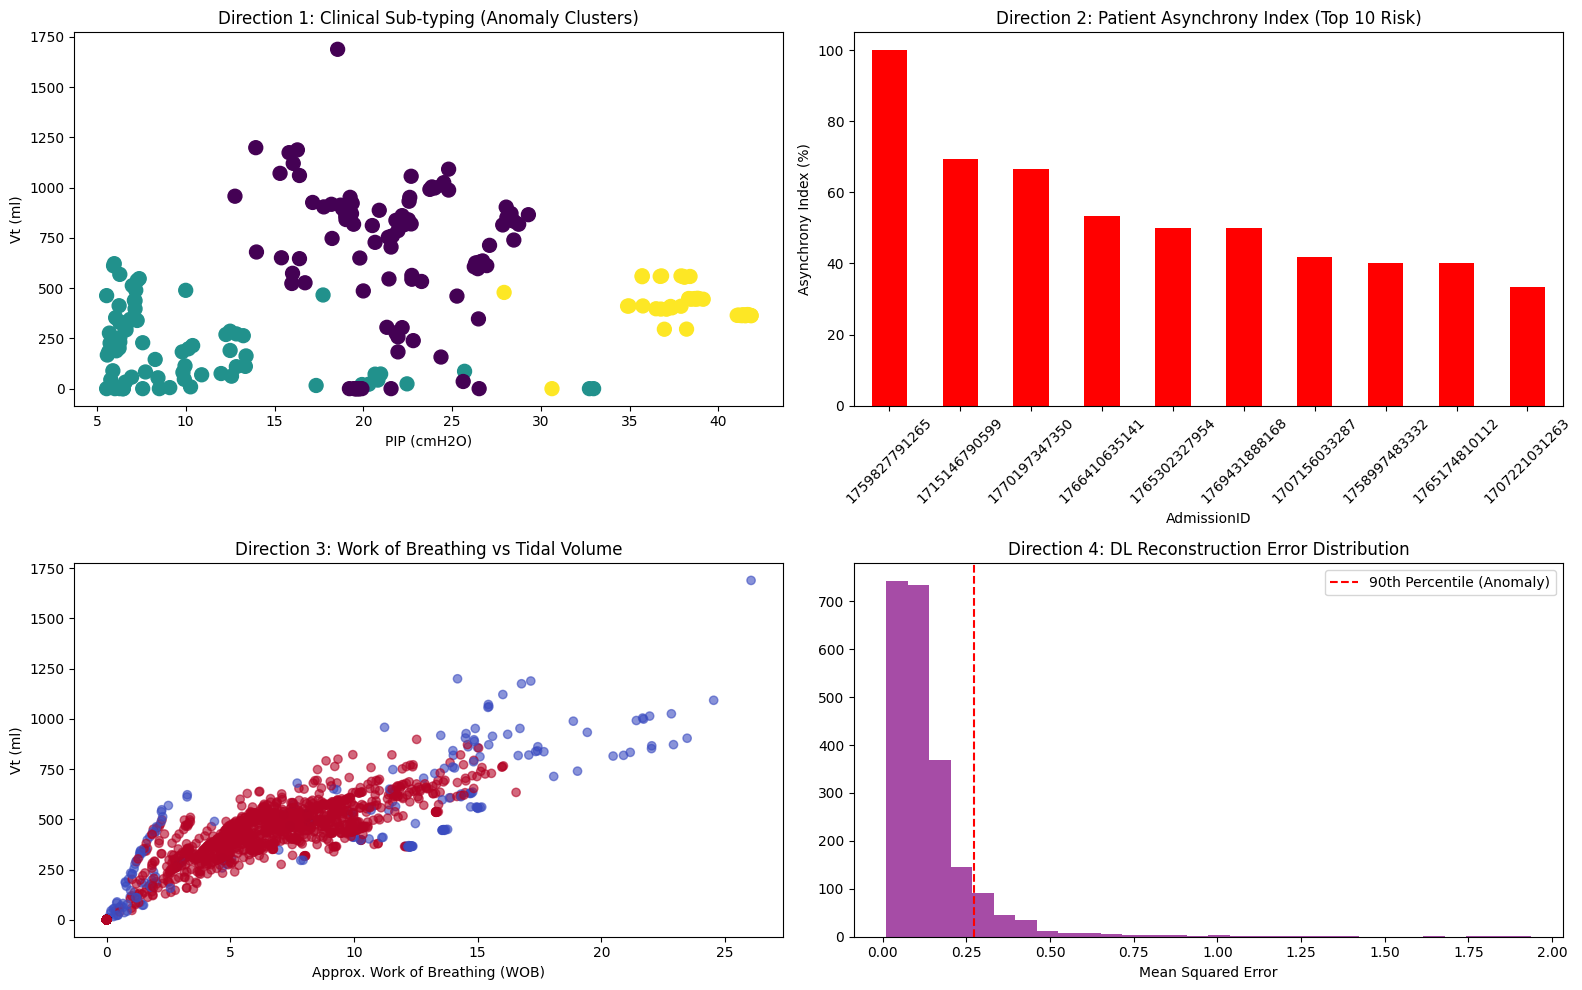

In [14]:
# 4: Deep Learning (Autoencoder)
print("\n--- ทิศทางที่ 4: Deep Learning Autoencoder ---")
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Input
    
    # 1. เตรียมข้อมูล Train
    X_dl = np.array(raw_waveforms_dl)
    X_dl_scaled = StandardScaler().fit_transform(X_dl)
    
    # 2. สร้างโครงสร้าง Autoencoder อย่างง่าย (1D)
    model = Sequential([
        Input(shape=(60,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'), # คอขวด (Bottleneck)
        Dense(32, activation='relu'),
        Dense(60, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mse')
    
    # 3. Train โมเดล (ให้เรียนรู้กราฟ Flow 60 จุด)
    # ในความเป็นจริงควร train เฉพาะข้อมูลปกติ แต่เพื่อโชว์ Concept เราจะเทรนทั้งหมดสั้นๆ
    model.fit(X_dl_scaled, X_dl_scaled, epochs=5, batch_size=16, verbose=0)
    
    # 4. ค้นหาความผิดปกติจาก Reconstruction Error
    X_pred = model.predict(X_dl_scaled, verbose=0)
    mse = np.mean(np.power(X_dl_scaled - X_pred, 2), axis=1)
    df_feat['DL_Reconstruction_Error'] = mse
    
    print("เทรน Deep Learning (Autoencoder) สำเร็จ!")
    print(f"Top 3 ลมหายใจที่ Deep Learning มองว่าหน้าตาแปลกที่สุด (Error สูงสุด):")
    print(df_feat.sort_values('DL_Reconstruction_Error', ascending=False)[['AdmissionID', 'Calculated_Vt_ml', 'DL_Reconstruction_Error']].head(3))
except Exception as e:
    print("ไม่สามารถรัน Deep Learning ได้ใน Environment นี้:", e)

# Plot สรุป Dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Sub-typing
axes[0,0].scatter(anomalies_df['PIP'], anomalies_df['Calculated_Vt_ml'], c=anomalies_df['Sub_Type'], cmap='viridis', s=100)
axes[0,0].set_title('Direction 1: Clinical Sub-typing (Anomaly Clusters)')
axes[0,0].set_xlabel('PIP (cmH2O)')
axes[0,0].set_ylabel('Vt (ml)')

# Plot 2: Patient AI%
patient_dash.sort_values('Asynchrony_Index_%', ascending=False).head(10).plot(
    kind='bar', x='AdmissionID', y='Asynchrony_Index_%', color='red', ax=axes[0,1], legend=False)
axes[0,1].set_title('Direction 2: Patient Asynchrony Index (Top 10 Risk)')
axes[0,1].set_ylabel('Asynchrony Index (%)')
axes[0,1].tick_params(axis='x', rotation=45)

# Plot 3: Advanced Feature (WOB vs Vt)
axes[1,0].scatter(df_feat['WOB_Approx'], df_feat['Calculated_Vt_ml'], c=df_feat['Anomaly'], cmap='coolwarm', alpha=0.6)
axes[1,0].set_title('Direction 3: Work of Breathing vs Tidal Volume')
axes[1,0].set_xlabel('Approx. Work of Breathing (WOB)')
axes[1,0].set_ylabel('Vt (ml)')

# Plot 4: DL Error distribution
axes[1,1].hist(df_feat['DL_Reconstruction_Error'], bins=30, color='purple', alpha=0.7)
axes[1,1].set_title('Direction 4: DL Reconstruction Error Distribution')
axes[1,1].set_xlabel('Mean Squared Error')
axes[1,1].axvline(np.percentile(df_feat['DL_Reconstruction_Error'], 90), color='red', linestyle='dashed', label='90th Percentile (Anomaly)')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('phd_advanced_insights.png')
plt.show()

In [16]:
# Export anomalies dataframe to CSV
anomalies_df.to_csv('anomalies_df.csv', index=False)
print('Saved anomalies_df.csv with', len(anomalies_df), 'rows')

Saved anomalies_df.csv with 222 rows


Plotting Completed!


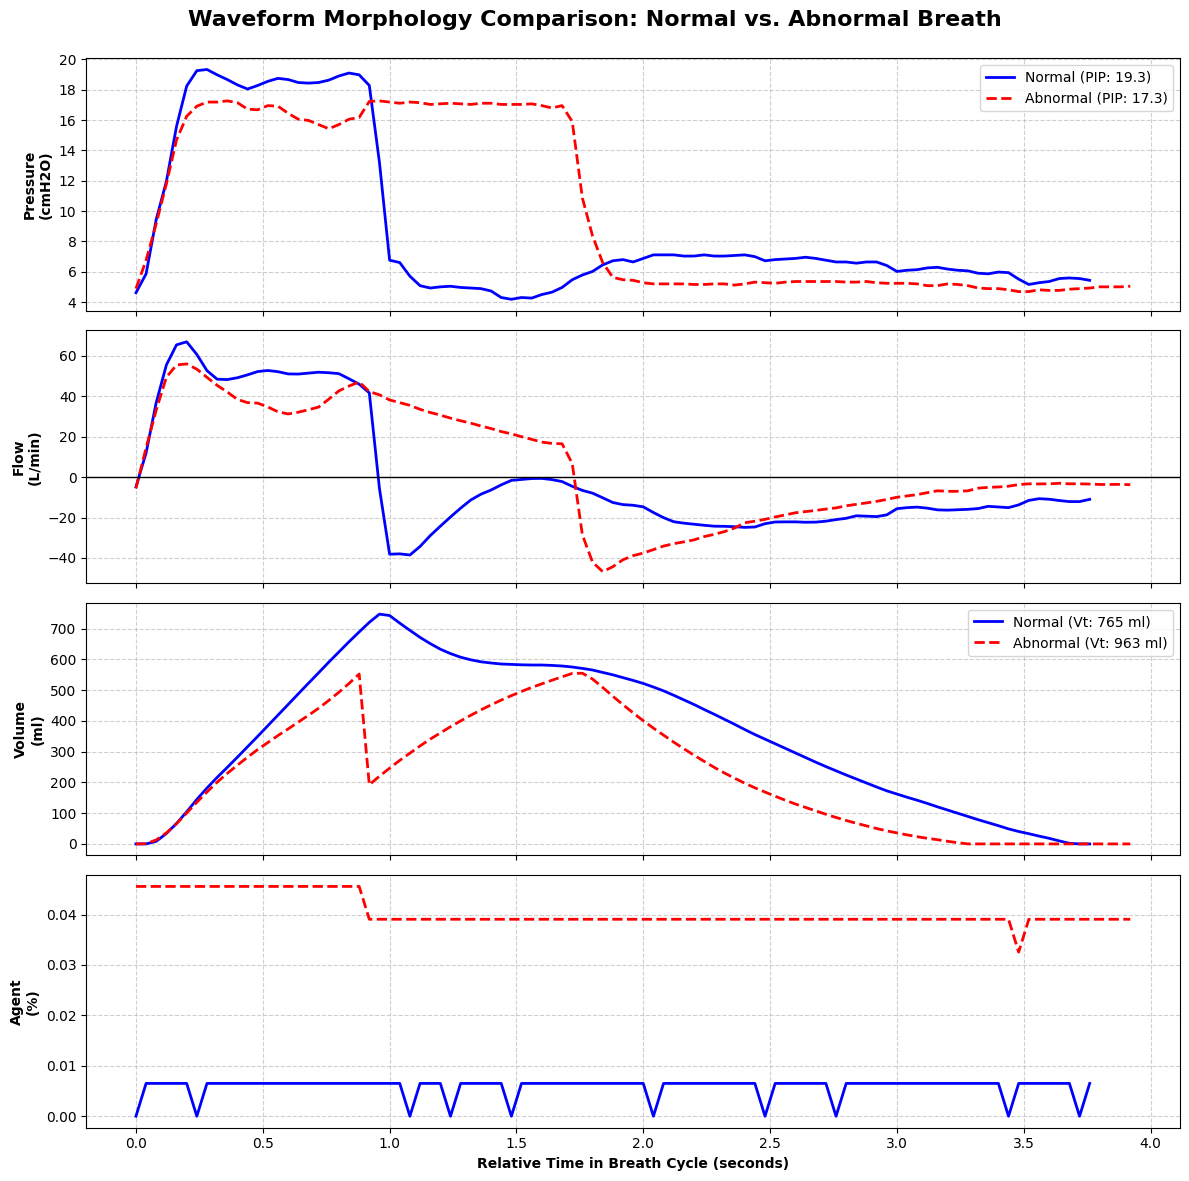

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# โหลดข้อมูล
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM']).head(100)

# ฟังก์ชัน Scaling ตามคู่มือ
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            s_val = int(h, 16)
            r_val = (s_val - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0
            vals.append(r_val)
        except:
            vals.append(0)
    return np.array(vals)

# ฟังก์ชันตัดแบ่งลมหายใจ
def segment_breaths(pressure_sig, flow_sig, vol_sig, agent_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    threshold = 2.0
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > threshold:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'breath_id': k+1,
                'duration': duration,
                'pressure': pressure_sig[idx_start:idx_end],
                'flow': flow_sig[idx_start:idx_end],
                'volume': vol_sig[idx_start:idx_end],
                'agent': agent_sig[idx_start:idx_end],
                'pip': np.max(pressure_sig[idx_start:idx_end]),
                'max_flow': np.max(flow_sig[idx_start:idx_end])
            })
    return breaths

# ประมวลผลข้อมูล
all_breaths = []
time_step = 0.04

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex, v_hex, a_hex = "", "", "", ""
    for b in blocks:
        p_hex += b[0:30]     # ชุดที่ 1: Pressure
        f_hex += b[30:60]    # ชุดที่ 2: Flow
        v_hex += b[60:90]    # ชุดที่ 3: Volume
        a_hex += b[90:120]   # ชุดที่ 4: Agent
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    volume = ge_scaling(v_hex, 512, 3584, 0, 2000)
    agent = ge_scaling(a_hex, 512, 3584, 0, 20)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, volume, agent, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        
        # ปรับ Baseline ของ Volume ดิบให้เริ่มที่ 0 เพื่อให้กราฟดูง่ายขึ้น
        raw_vol_corrected = b['volume'] - b['volume'][0] if len(b['volume'])>0 else b['volume']
        
        all_breaths.append({
            'AdmissionID': row['AdmissionID'],
            'PIP': b['pip'],
            'Max_Flow': b['max_flow'],
            'Calculated_Vt_ml': calc_vt,
            'pressure': b['pressure'],
            'flow': b['flow'],
            'volume': raw_vol_corrected,
            'agent': b['agent'],
            'duration': b['duration']
        })

df_feat = pd.DataFrame(all_breaths)

# AI Anomaly Detection
X = df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
iso = IsolationForest(contamination=0.1, random_state=42)
df_feat['Anomaly'] = iso.fit_predict(X)

normal_breaths = df_feat[df_feat['Anomaly'] == 1]
abnormal_breaths = df_feat[df_feat['Anomaly'] == -1]

# เลือกตัวแทนมาพล็อต
rep_norm = normal_breaths.iloc[1] # เลือกลมหายใจปกติ

# เลือกความผิดปกติแบบชัดเจน เช่น Double Triggering (Vt สูงๆ)
rep_abnorm = abnormal_breaths.sort_values('Calculated_Vt_ml', ascending=False).iloc[0]

# --- PLOTTING ---
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
fig.suptitle('Waveform Morphology Comparison: Normal vs. Abnormal Breath', fontsize=16, fontweight='bold')

# สร้างแกนเวลาสัมพัทธ์ (Relative Time) ให้เริ่มจาก 0
t_norm = np.arange(0, len(rep_norm['pressure']) * time_step, time_step)
t_abnorm = np.arange(0, len(rep_abnorm['pressure']) * time_step, time_step)

# 1. Pressure
axes[0].plot(t_norm, rep_norm['pressure'], color='blue', linewidth=2, label=f"Normal (PIP: {rep_norm['PIP']:.1f})")
axes[0].plot(t_abnorm, rep_abnorm['pressure'], color='red', linewidth=2, linestyle='--', label=f"Abnormal (PIP: {rep_abnorm['PIP']:.1f})")
axes[0].set_ylabel('Pressure\n(cmH2O)', fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend(loc='upper right')

# 2. Flow
axes[1].plot(t_norm, rep_norm['flow'], color='blue', linewidth=2)
axes[1].plot(t_abnorm, rep_abnorm['flow'], color='red', linewidth=2, linestyle='--')
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_ylabel('Flow\n(L/min)', fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)

# 3. Volume
axes[2].plot(t_norm, rep_norm['volume'], color='blue', linewidth=2, label=f"Normal (Vt: {rep_norm['Calculated_Vt_ml']:.0f} ml)")
axes[2].plot(t_abnorm, rep_abnorm['volume'], color='red', linewidth=2, linestyle='--', label=f"Abnormal (Vt: {rep_abnorm['Calculated_Vt_ml']:.0f} ml)")
axes[2].set_ylabel('Volume\n(ml)', fontweight='bold')
axes[2].grid(True, linestyle='--', alpha=0.6)
axes[2].legend(loc='upper right')

# 4. Anesthetic Agent
axes[3].plot(t_norm, rep_norm['agent'], color='blue', linewidth=2)
axes[3].plot(t_abnorm, rep_abnorm['agent'], color='red', linewidth=2, linestyle='--')
axes[3].set_ylabel('Agent\n(%)', fontweight='bold')
axes[3].set_xlabel('Relative Time in Breath Cycle (seconds)', fontweight='bold')
axes[3].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.savefig('morphology_comparison.png')
print("Plotting Completed!")

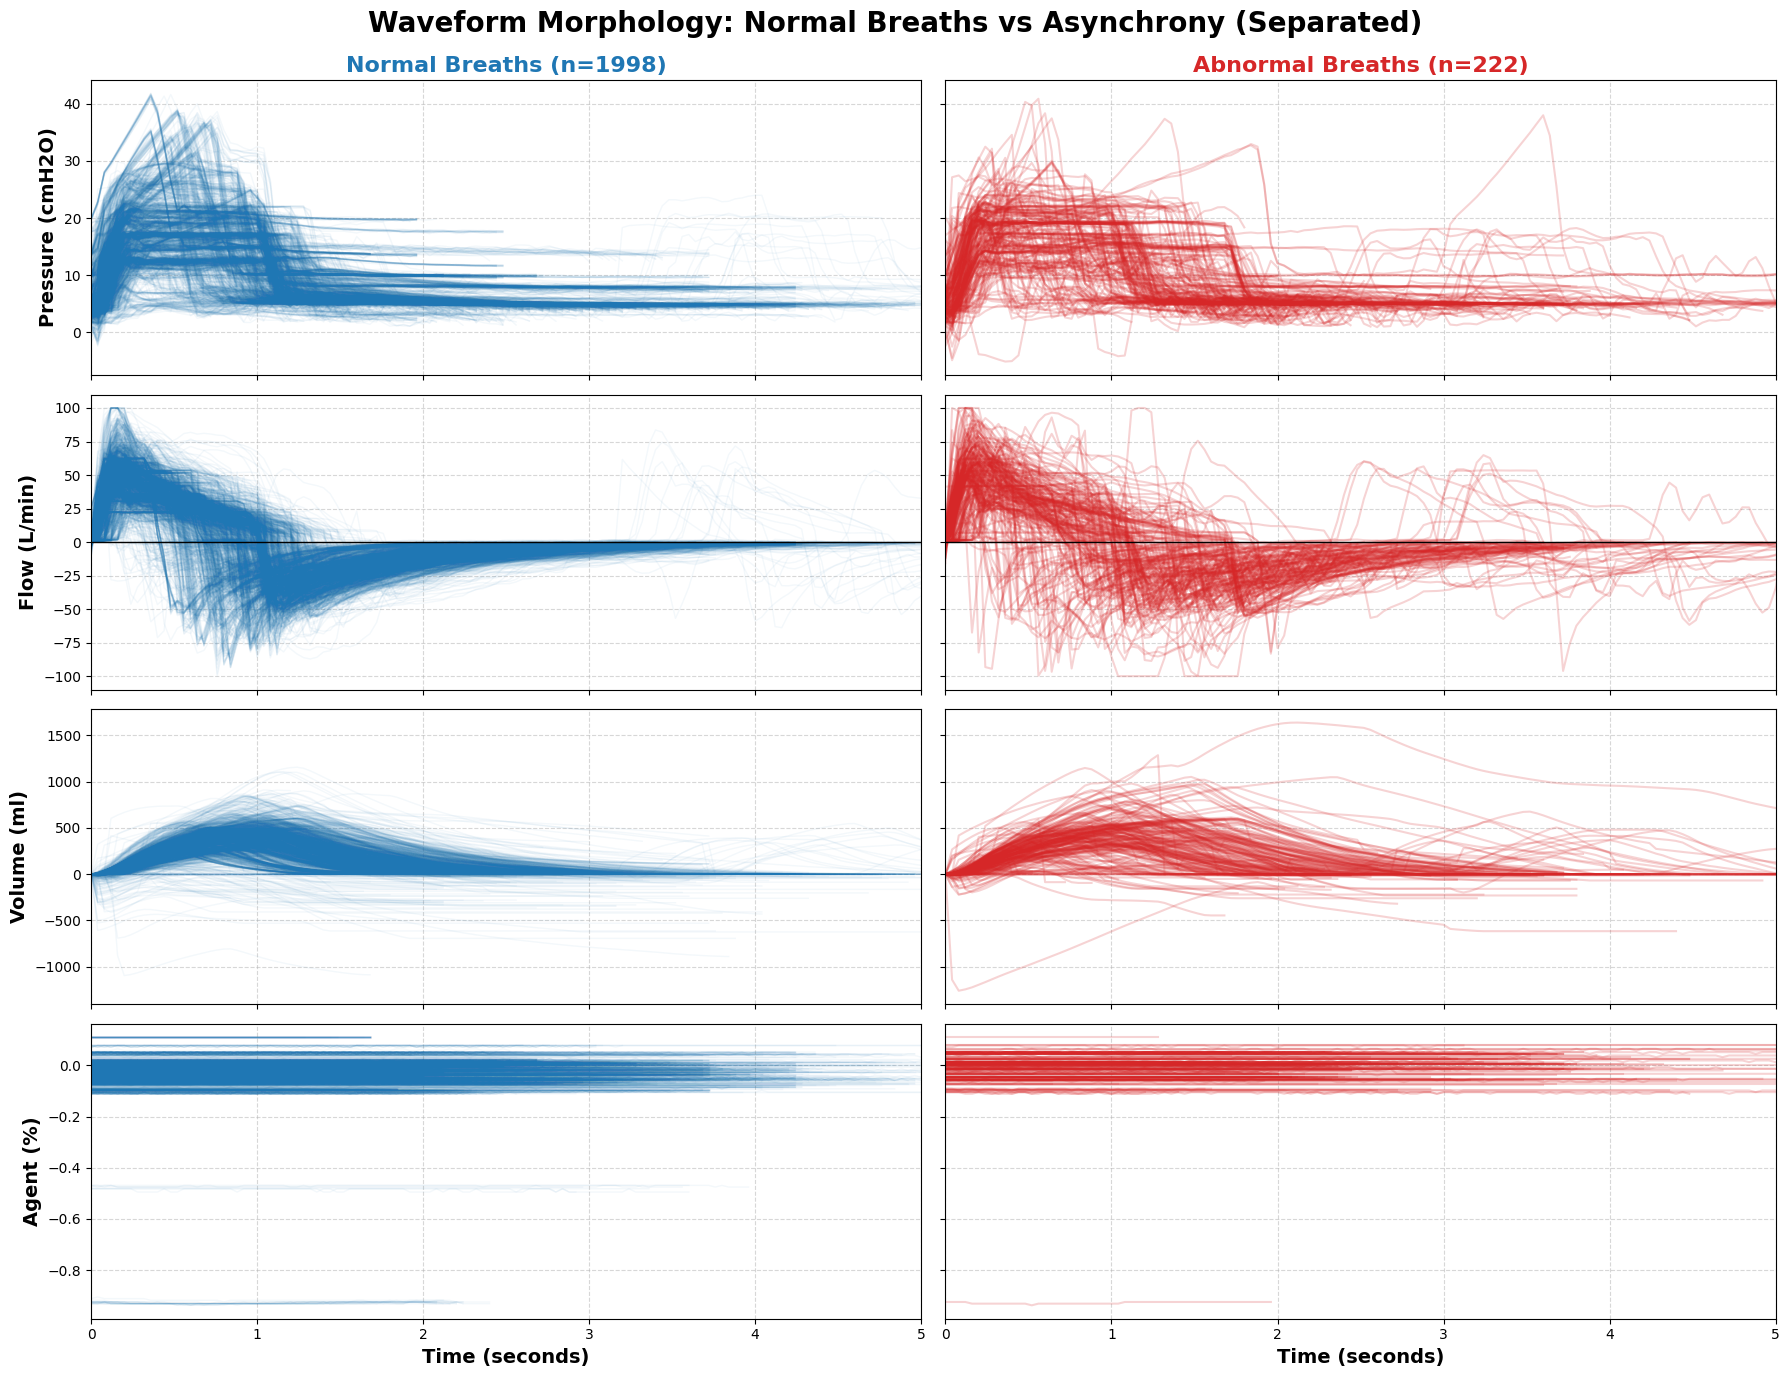

In [ ]:

#วาดกราฟแยก ซ้าย (Normal) - ขวา (Abnormal)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import warnings
warnings.filterwarnings('ignore')

# 1. โหลดข้อมูล (ใช้ 150 แถว)
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM']).head(150)

# 2. ฟังก์ชัน Scaling
def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            vals.append((int(h, 16) - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0)
        except:
            vals.append(0)
    return np.array(vals)

# 3. ฟังก์ชันตัดแบ่งลมหายใจ
def segment_breaths(pressure_sig, flow_sig, vol_sig, agent_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > 2.0:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'duration': duration,
                'pressure': pressure_sig[idx_start:idx_end],
                'flow': flow_sig[idx_start:idx_end],
                'volume': vol_sig[idx_start:idx_end],
                'agent': agent_sig[idx_start:idx_end]
            })
    return breaths

# 4. ประมวลผลและสกัดข้อมูล
all_breaths = []
time_step = 0.04
fixed_length = 80 # ความยาว 80 จุด = 3.2 วินาที สำหรับให้ DL เทรน

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex, v_hex, a_hex = "", "", "", ""
    for b in blocks:
        p_hex += b[0:30]; f_hex += b[30:60]; v_hex += b[60:90]; a_hex += b[90:120]
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    volume = ge_scaling(v_hex, 512, 3584, 0, 2000)
    agent = ge_scaling(a_hex, 512, 3584, 0, 20)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, volume, agent, time_axis)
    for b in breaths:
        # ตัดข้อมูลให้ยาวเท่ากัน (80 จุด) สำหรับโยนเข้า DL
        f_seg = b['flow']
        if len(f_seg) > fixed_length:
            f_padded = f_seg[:fixed_length]
        else:
            f_padded = np.pad(f_seg, (0, fixed_length - len(f_seg)), 'constant')
            
        raw_vol_corrected = b['volume'] - b['volume'][0] if len(b['volume'])>0 else b['volume']
        
        all_breaths.append({
            'pressure': b['pressure'],
            'flow': b['flow'],
            'volume': raw_vol_corrected,
            'agent': b['agent'],
            'dl_input_flow': f_padded
        })

df_feat = pd.DataFrame(all_breaths)

# 5. หาความผิดปกติด้วย Deep Learning (Autoencoder)
X_dl = np.stack(df_feat['dl_input_flow'].values)
scaler = StandardScaler()
X_dl_scaled = scaler.fit_transform(X_dl)

# สร้างสถาปัตยกรรม Autoencoder
model = Sequential([
    Input(shape=(fixed_length,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'), # Bottleneck 
    Dense(32, activation='relu'),
    Dense(fixed_length, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

# ฝึกฝนโมเดลด้วยตัวเอง (Unsupervised)
print("Training Autoencoder...")
model.fit(X_dl_scaled, X_dl_scaled, epochs=20, batch_size=16, verbose=0)

# หา Reconstruction Error (MSE)
X_pred = model.predict(X_dl_scaled, verbose=0)
mse = np.mean(np.power(X_dl_scaled - X_pred, 2), axis=1)

# ตั้งค่าให้ Error เกิน Percentile ที่ 90 ถือเป็นความผิดปกติ
threshold = np.percentile(mse, 90)
df_feat['Anomaly'] = [-1 if e > threshold else 1 for e in mse]

# สร้างกราฟขนาด 4 แถว (เซ็นเซอร์) 2 คอลัมน์ (Normal / Abnormal)
fig, axes = plt.subplots(4, 2, figsize=(18, 14), sharex=True, sharey='row')
fig.suptitle('Waveform Morphology: Normal Breaths vs Asynchrony (Separated)', fontsize=20, fontweight='bold')

# กำหนดแกน ซ้าย (0) และ ขวา (1)
col_normal = 0
col_abnormal = 1

for i, row in df_feat.iterrows():
    # จัดการเรื่องความยาว Array (ป้องกัน Error)
    n_pts = len(row['pressure']) if hasattr(row['pressure'], '__len__') else int(row['pressure'])
    t = np.arange(n_pts) * time_step
    
    if row['Anomaly'] == 1:
        # พล็อตลงคอลัมน์ซ้าย (Normal)
        axes[0, col_normal].plot(t, row['pressure'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[1, col_normal].plot(t, row['flow'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[2, col_normal].plot(t, row['volume'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[3, col_normal].plot(t, row['agent'], color='#1f77b4', alpha=0.05, linewidth=1)
    else:
        # พล็อตลงคอลัมน์ขวา (Abnormal)
        axes[0, col_abnormal].plot(t, row['pressure'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[1, col_abnormal].plot(t, row['flow'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[2, col_abnormal].plot(t, row['volume'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[3, col_abnormal].plot(t, row['agent'], color='#d62728', alpha=0.2, linewidth=1.5)

# ตกแต่งกราฟให้สวยงาม
sensor_names = ['Pressure (cmH2O)', 'Flow (L/min)', 'Volume (ml)', 'Agent (%)']

for row_idx in range(4):
    for col_idx in range(2):
        axes[row_idx, col_idx].grid(True, linestyle='--', alpha=0.5)
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(sensor_names[row_idx], fontweight='bold', fontsize=14)
        if row_idx == 1: # ใส่เส้นศูนย์ที่แกน Flow
            axes[row_idx, col_idx].axhline(0, color='black', linewidth=1)

axes[0, col_normal].set_title(f'Normal Breaths (n={len(df_feat[df_feat["Anomaly"]==1])})', fontsize=16, color='#1f77b4', fontweight='bold')
axes[0, col_abnormal].set_title(f'Abnormal Breaths (n={len(df_feat[df_feat["Anomaly"]==-1])})', fontsize=16, color='#d62728', fontweight='bold')

axes[3, col_normal].set_xlabel('Time (seconds)', fontweight='bold', fontsize=14)
axes[3, col_abnormal].set_xlabel('Time (seconds)', fontweight='bold', fontsize=14)

plt.xlim(0, 5) # ซูมดูแค่ 5 วินาทีแรก
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('separated_spaghetti_plot.png')
plt.show()

Side-by-Side ML Plot saved successfully.


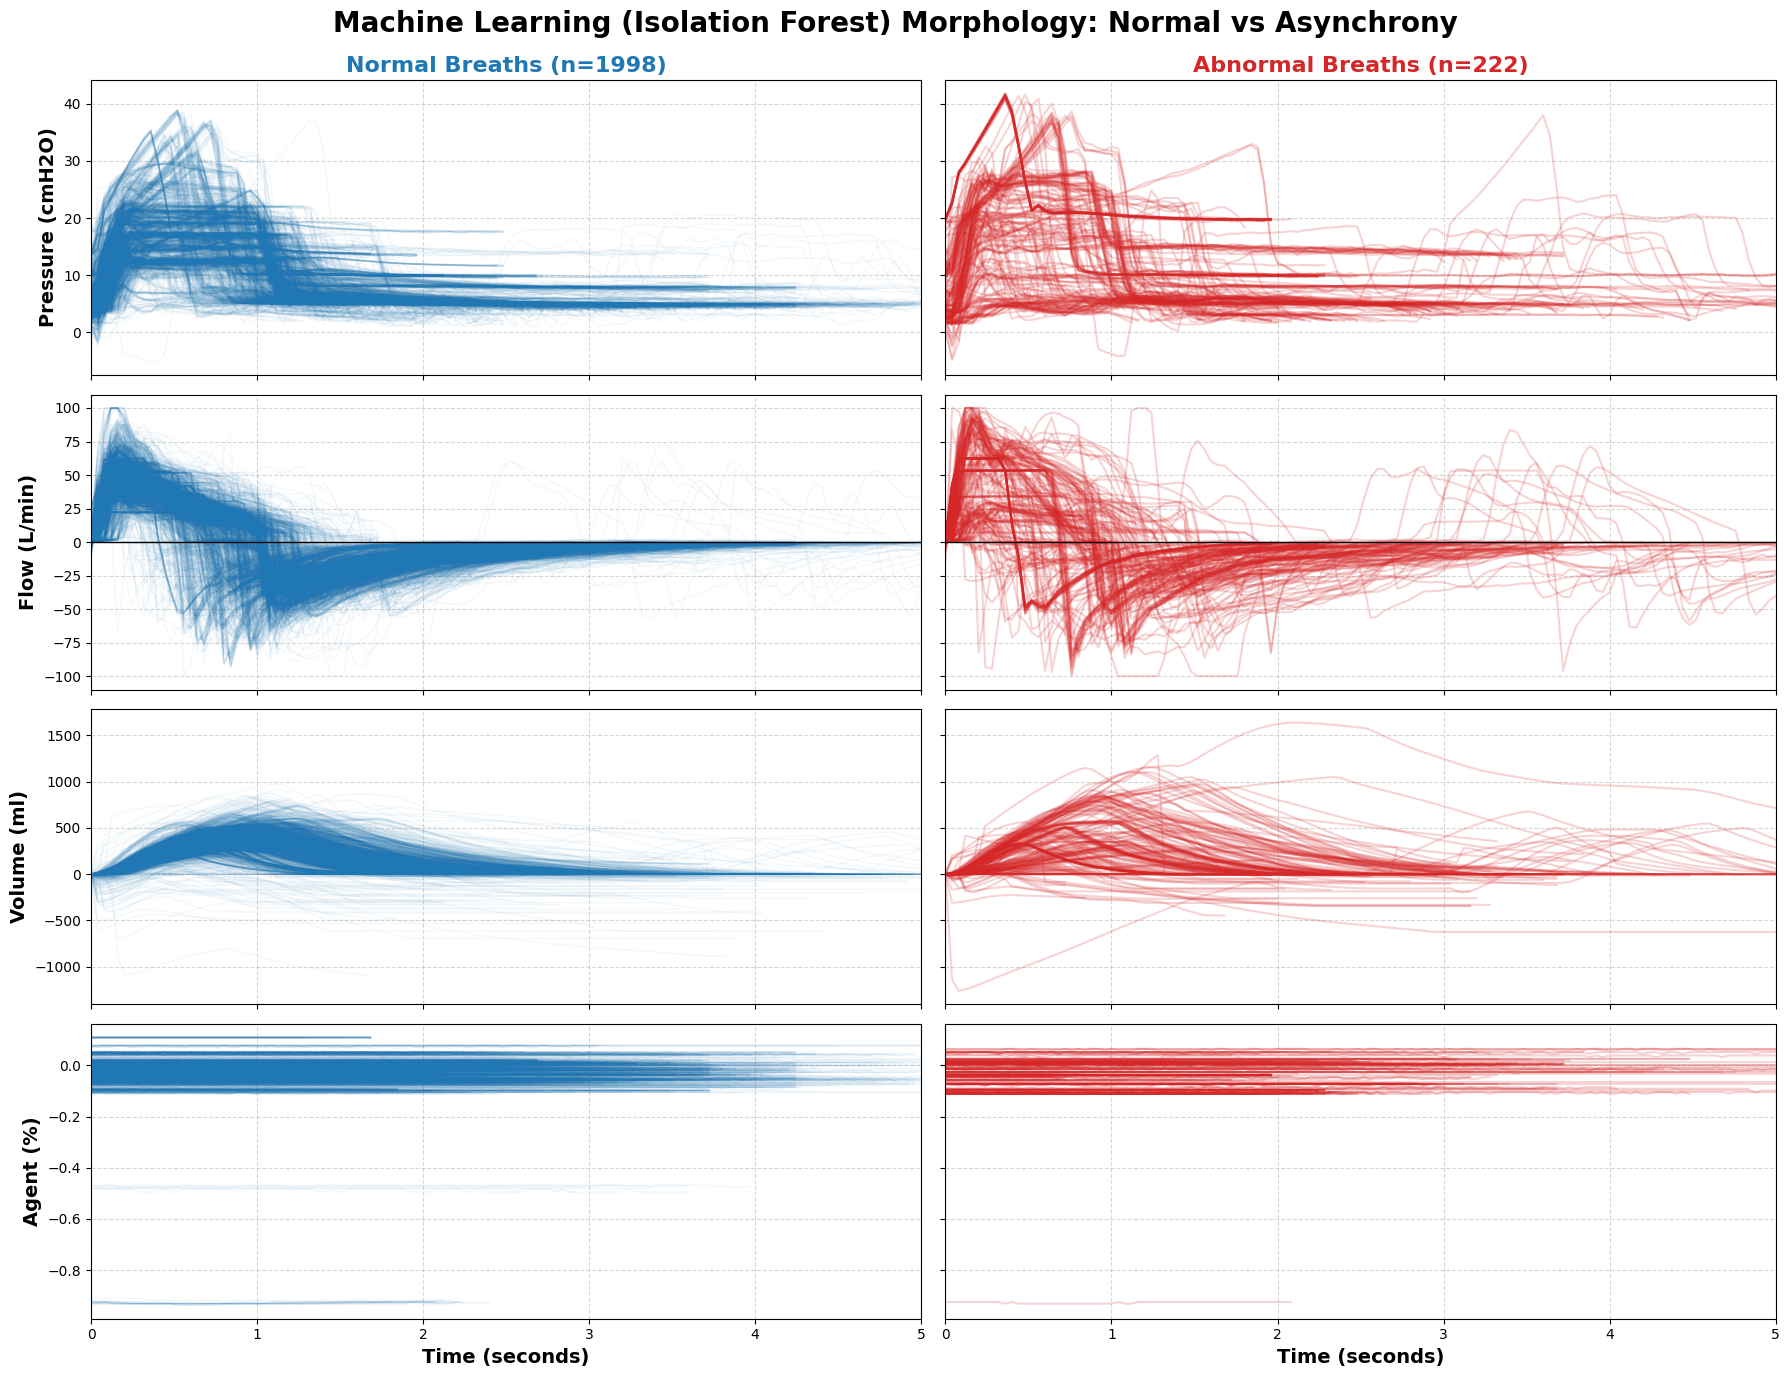

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# 1. 
df = pd.read_csv('mv_waveform_2026-02-05.csv').dropna(subset=['RAW_WAVEFORM'])

def ge_scaling(hex_string, scaled_0, scaled_1, raw_0, raw_1):
    chunks = [hex_string[i:i+3] for i in range(0, len(hex_string), 3)]
    vals = []
    for h in chunks:
        try:
            vals.append((int(h, 16) - scaled_0) * (raw_1 - raw_0) / (scaled_1 - scaled_0) + raw_0)
        except:
            vals.append(0)
    return np.array(vals)

def segment_breaths(pressure_sig, flow_sig, vol_sig, agent_sig, time_sig):
    flow_smooth = pd.Series(flow_sig).rolling(window=3, center=True).mean().fillna(0).values
    inspiratory_starts = []
    for i in range(1, len(flow_smooth)):
        if flow_smooth[i-1] < 0 and flow_smooth[i] >= 0:
            if i+5 < len(flow_smooth) and np.max(flow_smooth[i:i+5]) > 2.0:
                inspiratory_starts.append(i)
    
    breaths = []
    for k in range(len(inspiratory_starts) - 1):
        idx_start = inspiratory_starts[k]
        idx_end = inspiratory_starts[k+1]
        duration = time_sig[idx_end] - time_sig[idx_start]
        if duration > 0.5:
            breaths.append({
                'duration': duration,
                'pressure': pressure_sig[idx_start:idx_end],
                'flow': flow_sig[idx_start:idx_end],
                'volume': vol_sig[idx_start:idx_end],
                'agent': agent_sig[idx_start:idx_end],
                'pip': np.max(pressure_sig[idx_start:idx_end]),
                'max_flow': np.max(flow_sig[idx_start:idx_end])
            })
    return breaths

all_breaths = []
time_step = 0.04

for index, row in df.iterrows():
    raw_text = str(row['RAW_WAVEFORM']).replace('=', '')
    blocks = [b.strip()[:120] for b in raw_text.split(':VTw') if len(b.strip()) >= 120]
    if not blocks: continue
        
    p_hex, f_hex, v_hex, a_hex = "", "", "", ""
    for b in blocks:
        p_hex += b[0:30]; f_hex += b[30:60]; v_hex += b[60:90]; a_hex += b[90:120]
        
    pressure = ge_scaling(p_hex, 0, 3584, -20, 120)
    flow = ge_scaling(f_hex, 512, 3584, -100, 100)
    volume = ge_scaling(v_hex, 512, 3584, 0, 2000)
    agent = ge_scaling(a_hex, 512, 3584, 0, 20)
    time_axis = np.arange(0, len(pressure) * time_step, time_step)
    
    breaths = segment_breaths(pressure, flow, volume, agent, time_axis)
    for b in breaths:
        insp_flow = b['flow'][b['flow'] > 0]
        calc_vt = np.sum(insp_flow) / 60 * time_step * 1000
        raw_vol_corrected = b['volume'] - b['volume'][0] if len(b['volume'])>0 else b['volume']
        
        all_breaths.append({
            'PIP': b['pip'],
            'Max_Flow': b['max_flow'],
            'Calculated_Vt_ml': calc_vt,
            'pressure': b['pressure'],
            'flow': b['flow'],
            'volume': raw_vol_corrected,
            'agent': b['agent']
        })

df_feat = pd.DataFrame(all_breaths)

# ML Anomaly Detection (Isolation Forest)
X = df_feat[['PIP', 'Max_Flow', 'Calculated_Vt_ml']]
iso = IsolationForest(contamination=0.1, random_state=42)
df_feat['Anomaly'] = iso.fit_predict(X)

# วาดกราฟแยกซ้าย-ขวา แบบ Side-by-Side สำหรับ ML
fig, axes = plt.subplots(4, 2, figsize=(18, 14), sharex=True, sharey='row')
fig.suptitle('Machine Learning (Isolation Forest) Morphology: Normal vs Asynchrony', fontsize=20, fontweight='bold')

col_normal = 0
col_abnormal = 1

for i, row in df_feat.iterrows():
    n_pts = len(row['pressure']) if hasattr(row['pressure'], '__len__') else int(row['pressure'])
    t = np.arange(n_pts) * time_step
    
    if row['Anomaly'] == 1:
        axes[0, col_normal].plot(t, row['pressure'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[1, col_normal].plot(t, row['flow'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[2, col_normal].plot(t, row['volume'], color='#1f77b4', alpha=0.05, linewidth=1)
        axes[3, col_normal].plot(t, row['agent'], color='#1f77b4', alpha=0.05, linewidth=1)
    else:
        axes[0, col_abnormal].plot(t, row['pressure'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[1, col_abnormal].plot(t, row['flow'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[2, col_abnormal].plot(t, row['volume'], color='#d62728', alpha=0.2, linewidth=1.5)
        axes[3, col_abnormal].plot(t, row['agent'], color='#d62728', alpha=0.2, linewidth=1.5)

sensor_names = ['Pressure (cmH2O)', 'Flow (L/min)', 'Volume (ml)', 'Agent (%)']

for row_idx in range(4):
    for col_idx in range(2):
        axes[row_idx, col_idx].grid(True, linestyle='--', alpha=0.5)
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(sensor_names[row_idx], fontweight='bold', fontsize=14)
        if row_idx == 1:
            axes[row_idx, col_idx].axhline(0, color='black', linewidth=1)

axes[0, col_normal].set_title(f'Normal Breaths (n={len(df_feat[df_feat["Anomaly"]==1])})', fontsize=16, color='#1f77b4', fontweight='bold')
axes[0, col_abnormal].set_title(f'Abnormal Breaths (n={len(df_feat[df_feat["Anomaly"]==-1])})', fontsize=16, color='#d62728', fontweight='bold')

axes[3, col_normal].set_xlabel('Time (seconds)', fontweight='bold', fontsize=14)
axes[3, col_abnormal].set_xlabel('Time (seconds)', fontweight='bold', fontsize=14)

plt.xlim(0, 5)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('ml_separated_spaghetti_plot.png')
print("Side-by-Side ML Plot saved successfully.")